<a href="https://colab.research.google.com/github/HeshanDissanayake/SIIM_ISIC_melanoma_classification/blob/main/SIIM_ISIC_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!curl 'https://storage.googleapis.com/kaggle-data-sets/687793%2F1205903%2Fbundle%2Farchive.zip?GoogleAccessId=gcp-kaggle-com@kaggle-161607.iam.gserviceaccount.com&Expires=1593589684&Signature=LcxgnbiM%2F5PPd0JKxHicnECt2NL%2BcykjTmNOzB%2BXZ%2F69qd%2BxQxa5yxz%2FB6Kqfcrq8FjXdn3DVv3%2FNywwi7RSsQZQsZccXoDZd99VDKIxg77RwNwjUMO%2FeWO5xDm9Boy%2FE32vPvhKlnBRo3umwT5gmdRx0PfFyWytcVAs4Z1P6L%2FLjcg68Lza2P1hpJdidqTZ%2BS4QPU0PmB8L8%2Bu4ovJE2ZbmCDOiBr5pysM1ynHXBEBNYKyH0CeckZaDMkUbp%2Bl2OwgtbUnj4US83N0sOwiwSDtJuIiO07glim8VEH9gpnJbUyCfEMQgoOyxTJxmnmAbUySuRgBw5Jo0cKHZ%2F8wo4g%3D%3D' -H 'User-Agent: Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:77.0) Gecko/20100101 Firefox/77.0' -H 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8' -H 'Accept-Language: en-US,en;q=0.5' --compressed -H 'Referer: https://www.kaggle.com/' -H 'Connection: keep-alive' -H 'Cookie: cuntwars_user_id=xXNhMHwAmW; _ga=GA1.3.1485321816.1568920993' -H 'Upgrade-Insecure-Requests: 1' -H 'TE: Trailers' -o cancer.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2021M  100 2021M    0     0  37.8M      0  0:00:53  0:00:53 --:--:-- 52.8M


In [ ]:
!apt-get install transmission-cli

In [ ]:
!transmission-cli -w '/content' magnet:?xt=urn:btih:8cdf20be1135440f5d06b579884fa2cb0038ecca&dn=Dark%2B-%2BSeason%2B03%2B%28Dual-Audio%2BGer-Eng%29%2B%28ESubs%29%2B%281080p%29%2B%2810bit%2B6CH%29&tr=udp%3A%2F%2Ftracker.openbittorrent.com%3A80%2Fannounce&tr=udp%3A%2F%2Ftracker.zer0day.to%3A1337%2Fannounce&tr=udp%3A%2F%2Ftracker.leechers-paradise.org%3A6969%2Fannounce&tr=udp%3A%2F%2Fcoppersurfer.tk%3A6969%2Fannounce

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!cp -r /content/aa /content/drive/My\ Drive/dark3

In [ ]:
import os
import sys
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copy
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, add, Dropout, Flatten, Dense, Reshape, GaussianNoise
from tensorflow.keras.models import Model
from zipfile import ZipFile
import sys
from tensorflow.keras.models import Sequential, load_model
from  tensorflow import keras
from tensorflow.keras import regularizers

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
allData = pd.read_csv('/content/train.csv', sep = ',')
df = pd.DataFrame(allData)
malignant = df.groupby(df.target).get_group(1) 
benign = df.groupby(df.target).get_group(0)

malignant_file_names = malignant.image_name.values
benign_file_names = benign.image_name.values

In [ ]:
len(malignant_file_names)


584

In [ ]:

!mkdir Data /content/Data/maignant
# !rm -R /content/300x300 /content/640x640/test

In [ ]:
!rm -R /content/640x640

In [ ]:
source = '/content/640x640/train'
dest = '/content/Data/maignant' 
for i,file in enumerate(malignant_file_names):
  os.system('cp -r %s %s'%(source+'/'+file+'.jpg', dest+'/'+file+'.jpg'))
  os.system('rm -r %s'%(source+'/'+file+'.jpg'))  
  sys.stdout.write('\r %d%%: Copying %s to %s'%((i/len(malignant_file_names))*100, file, dest))
  sys.stdout.flush()
print("\rComplete")

Complete


In [ ]:
datagen = ImageDataGenerator(rescale = 1./255)
traingen =  datagen.flow_from_directory(directory='/content/300x300', class_mode= 'input' , target_size=(320, 320), batch_size=50)

Found 44108 images belonging to 2 classes.


In [ ]:
input_layer = Input(shape = (320, 320, 3)) 
noised = GaussianNoise(0.25)(input_layer)
l1 = Conv2D(16, (3,3), activation='relu', padding='same')(noised) 
l2 = Conv2D(16, (3,3), activation='relu', padding='same')(l1) 
l3 = MaxPooling2D((2,2))(l2)

l4 = Conv2D(32, (3,3), activation='relu', padding='same')(l3) 
l5 = Conv2D(32, (3,3), activation='relu', padding='same')(l4) 
l6 = MaxPooling2D((2,2))(l5)

l7 = Conv2D(64, (3,3), activation='relu', padding='same')(l6) 
l8 = MaxPooling2D((2,2))(l7)

l9 = Conv2D(64, (3,3), activation='relu', padding='same')(l8) 
l10 = MaxPooling2D((2,2))(l9)

l11 = Conv2D(128, (3,3), activation='relu', padding='same')(l10) 
l12 = MaxPooling2D((2,2))(l11)

l13 = Flatten()(l12) 
l14= Dense(200, activation='relu', kernel_regularizer=regularizers.l2(10e-10))(l13) 

encoder = Model(input_layer, l14) 
encoder.summary()


Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 320, 320, 3)]     0         
_________________________________________________________________
gaussian_noise_3 (GaussianNo (None, 320, 320, 3)       0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 320, 320, 16)      448       
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 320, 320, 16)      2320      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 160, 160, 16)      0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 160, 160, 32)      4640      
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 160, 160, 32)      9248

In [ ]:

l15 = Dense(12800, activation='relu', kernel_regularizer=regularizers.l2(10e-10))(l14)

l16 = Reshape((10, 10, 128))(l15)

l17 = UpSampling2D()(l16)
l18 = Conv2D(128, (3,3), activation='relu', padding='same')(l17)

l19 = UpSampling2D()(l18)
l20 = Conv2D(64, (3,3), activation='relu', padding='same')(l19)

l21 = UpSampling2D()(l20)
l22 = Conv2D(64, (3,3), activation='relu', padding='same')(l21)

l23 = UpSampling2D()(l22)
l24 = Conv2D(32, (3,3), activation='relu', padding='same')(l23)
l25 = Conv2D(32, (3,3), activation='relu', padding='same')(l24)

l26 = UpSampling2D()(l25)
l27 = Conv2D(16, (3,3), activation='relu', padding='same')(l26)
l28 = Conv2D(16, (3,3), activation='relu', padding='same')(l27)

l29 = Conv2D(3, (3,3), activation='relu', padding='same')(l28)

auto_encoder = Model(input_layer, l29)
auto_encoder.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 320, 320, 3)]     0         
_________________________________________________________________
gaussian_noise_3 (GaussianNo (None, 320, 320, 3)       0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 320, 320, 16)      448       
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 320, 320, 16)      2320      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 160, 160, 16)      0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 160, 160, 32)      4640      
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 160, 160, 32)      9248

In [ ]:
auto_encoder.compile(optimizer = 'adam', loss = 'mse')

Epoch 1/200
100/100 [==============================] - ETA: 0s - loss: 0.0842

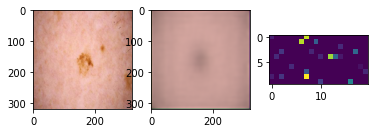

100/100 [==============================] - 116s 1s/step - loss: 0.0842
Epoch 2/200
100/100 [==============================] - ETA: 0s - loss: 0.0090

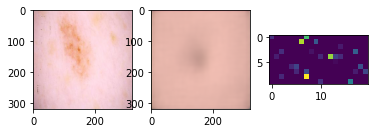

100/100 [==============================] - 112s 1s/step - loss: 0.0090
Epoch 3/200
100/100 [==============================] - ETA: 0s - loss: 0.0073

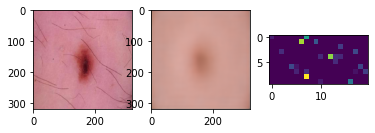

100/100 [==============================] - 112s 1s/step - loss: 0.0073
Epoch 4/200
100/100 [==============================] - ETA: 0s - loss: 0.0056

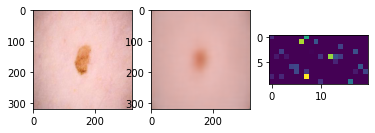

100/100 [==============================] - 112s 1s/step - loss: 0.0056
Epoch 5/200
100/100 [==============================] - ETA: 0s - loss: 0.0051

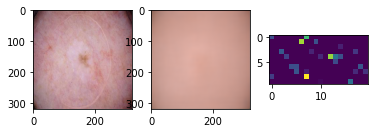

100/100 [==============================] - 112s 1s/step - loss: 0.0051
Epoch 6/200
100/100 [==============================] - ETA: 0s - loss: 0.0050

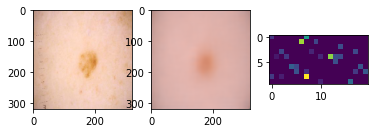

100/100 [==============================] - 111s 1s/step - loss: 0.0050
Epoch 7/200
100/100 [==============================] - ETA: 0s - loss: 0.0047

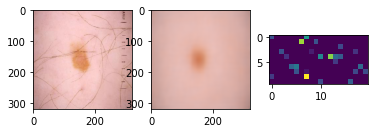

100/100 [==============================] - 112s 1s/step - loss: 0.0047
Epoch 8/200
100/100 [==============================] - ETA: 0s - loss: 0.0041

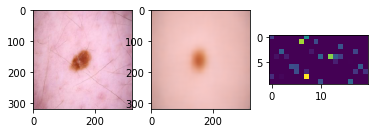

100/100 [==============================] - 111s 1s/step - loss: 0.0041
Epoch 9/200
100/100 [==============================] - ETA: 0s - loss: 0.0039

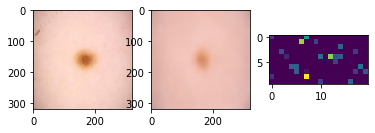

100/100 [==============================] - 111s 1s/step - loss: 0.0039
Epoch 10/200
100/100 [==============================] - ETA: 0s - loss: 0.0039

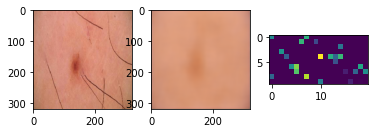

100/100 [==============================] - 112s 1s/step - loss: 0.0039
Epoch 11/200
100/100 [==============================] - ETA: 0s - loss: 0.0038

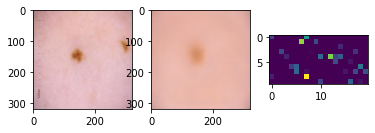

100/100 [==============================] - 112s 1s/step - loss: 0.0038
Epoch 12/200
100/100 [==============================] - ETA: 0s - loss: 0.0035

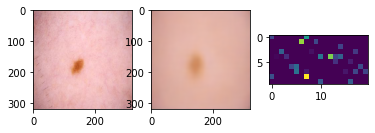

100/100 [==============================] - 112s 1s/step - loss: 0.0035
Epoch 13/200
100/100 [==============================] - ETA: 0s - loss: 0.0040

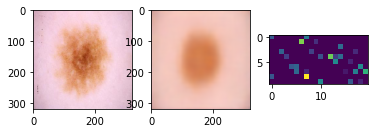

100/100 [==============================] - 112s 1s/step - loss: 0.0040
Epoch 14/200
100/100 [==============================] - ETA: 0s - loss: 0.0035

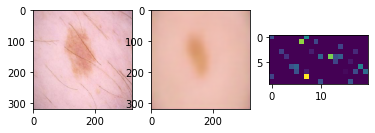

100/100 [==============================] - 111s 1s/step - loss: 0.0035
Epoch 15/200
100/100 [==============================] - ETA: 0s - loss: 0.0034

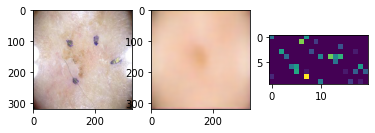

100/100 [==============================] - 112s 1s/step - loss: 0.0034
Epoch 16/200
100/100 [==============================] - ETA: 0s - loss: 0.0035

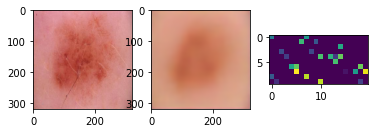

100/100 [==============================] - 113s 1s/step - loss: 0.0035
Epoch 17/200
100/100 [==============================] - ETA: 0s - loss: 0.0035

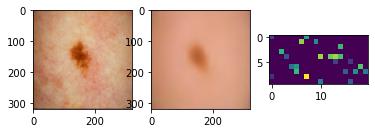

100/100 [==============================] - 113s 1s/step - loss: 0.0035
Epoch 18/200
100/100 [==============================] - ETA: 0s - loss: 0.0031

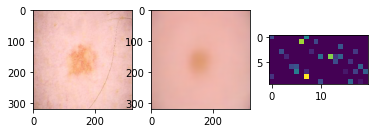

100/100 [==============================] - 113s 1s/step - loss: 0.0031
Epoch 19/200
100/100 [==============================] - ETA: 0s - loss: 0.0029

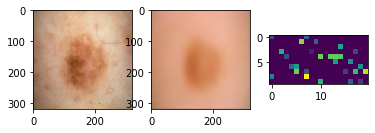

100/100 [==============================] - 112s 1s/step - loss: 0.0029
Epoch 20/200
100/100 [==============================] - ETA: 0s - loss: 0.0037

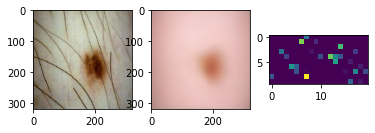

100/100 [==============================] - 112s 1s/step - loss: 0.0037
Epoch 21/200
100/100 [==============================] - ETA: 0s - loss: 0.0031

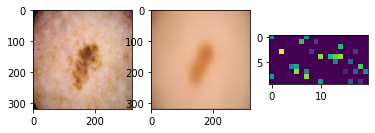

100/100 [==============================] - 112s 1s/step - loss: 0.0031
Epoch 22/200
100/100 [==============================] - ETA: 0s - loss: 0.0027

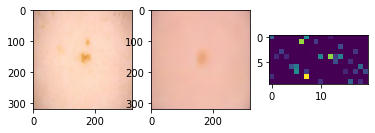

100/100 [==============================] - 112s 1s/step - loss: 0.0027
Epoch 23/200
100/100 [==============================] - ETA: 0s - loss: 0.0027

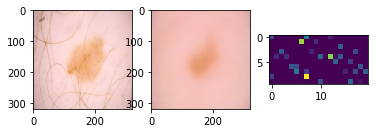

100/100 [==============================] - 112s 1s/step - loss: 0.0027
Epoch 24/200
 90/100 [==========================>...] - ETA: 11s - loss: 0.0028

In [ ]:
history = auto_encoder.fit(traingen, epochs=200 , steps_per_epoch=100, callbacks=[callback])

In [ ]:
 
class Callback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
      keys = list(logs.keys())
      show()
      if((epoch+1)%50 == 0):
        dir = '/content/drive/My Drive/cancer/models/autoencoder_noise_input/epoch_%d.h5'%epoch
        auto_encoder.save(dir)
def show():
  for batch in traingen:
    
    plt.subplot(1,3,1)
    plt.imshow(batch[0][6,:,:,:])
    pred = auto_encoder.predict(batch[0])
    latent = encoder.predict(batch[0])

    plt.subplot(1,3,2)  
    plt.imshow(pred[6])
    
    plt.subplot(1,3,3)  
    plt.imshow(np.reshape(latent[6],(10,20)))
    
    plt.show()
    break
callback = Callback()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
M_datagen = ImageDataGenerator(rescale = 1./255)
M_traingen =  M_datagen.flow_from_directory(directory='/content/Data', class_mode= 'input' , target_size=(320, 320), batch_size=20)

Found 584 images belonging to 1 classes.


In [ ]:
 for batch in M_traingen:
    
    plt.subplot(1,3,1)
    plt.imshow(batch[0][6,:,:,:])
    pred = auto_encoder.predict(batch[0])
    latent = encoder.predict(batch[0])

    plt.subplot(1,3,2)  
    plt.imshow(pred[6])
    
    plt.subplot(1,3,3)  
    plt.imshow(np.reshape(latent[6],(10,10)))
    
    plt.show()
    break

In [ ]:
dir = 

In [ ]:
net = load_model('/content/drive/My Drive/cancer/models/autoencoder_noise_input/epoch_199.h5')
for layer in net.layers:
  layer.trainable = False


In [ ]:
net.summary()

In [ ]:
latent_layer = net.get_layer('dense_11')
latent_out = latent_layer.output

L1 = Dense(300, activation= 'relu', kernel_regularizer=regularizers.l1(10e-10))(latent_out)
L1 = Dropout(0.1, name = 'asd')(L1)
L1 = Dense(300, activation= 'relu', kernel_regularizer=regularizers.l1(10e-10))(L1)
L1 = Dropout(0.1, name = 'asd2')(L1)
out = Dense(1, activation= 'sigmoid')(L1)

new_model = Model(net.input, out)
new_model.summary()

In [ ]:
!mkdir  /content/Data/benign

In [ ]:
file_list = []
for root,dir, files in os.walk("/content/640x640/train"):
  file_list = files

source = "/content/640x640/train/"
dest = "/content/Data/benign/"
for i in range(1100):
  os.system("cp %s %s"%(source+file_list[i], dest+file_list[i]))
  print(source+file_list[i], dest+file_list[i])

In [ ]:
datagen = ImageDataGenerator(rescale = 1./255,
                             rotation_range=0.5,
                              zoom_range = 0.2,
                              fill_mode="nearest",
                              horizontal_flip=True,
                              vertical_flip=True)
traingen =  datagen.flow_from_directory(directory='/content/Data', class_mode= 'binary' , target_size=(320, 320), batch_size=50)

Found 1684 images belonging to 2 classes.


In [ ]:
new_model.compile(optimizer = 'sgd' , loss = "binary_crossentropy", metrics=['accuracy'])

In [ ]:
new_model.fit(traingen, steps_per_epoch=33, epochs= 20)

In [ ]:
output = []
for root,dir,files in os.walk('/content/640x640/test'):
  for i,image in enumerate(files):
    image_name = image.strip('.jpg')
    img =  plt.imread(root+'/'+image)
    img = cv2.resize(img,(320,320)).reshape(1,320,320,3)
    prediction = new_model.predict(img/255)
    print(int((i/len(files))*100),image_name, round(prediction[0][0],5))
    output.append([image_name,round(prediction[0][0],5)])

Streaming output truncated to the last 5000 lines.
54 ISIC_7941445 0.00138
54 ISIC_3288360 0.79326
54 ISIC_4686358 0.07976
54 ISIC_3703571 0.21853
54 ISIC_2091552 0.82867
54 ISIC_4703373 0.41532
54 ISIC_4255739 0.13634
54 ISIC_2467742 0.2301
54 ISIC_6666968 0.22181
54 ISIC_0587024 0.76791
54 ISIC_3664322 0.3307
54 ISIC_2195519 0.23455
54 ISIC_3586356 0.13024
54 ISIC_7360390 0.00811
54 ISIC_3451507 0.15385
54 ISIC_2314219 0.04872
54 ISIC_9080748 0.03483
54 ISIC_6645129 0.00301
54 ISIC_4625309 0.15317
54 ISIC_7190481 0.1716
54 ISIC_3678349 0.8206
54 ISIC_8157391 0.49519
54 ISIC_2333413 0.00615
54 ISIC_9061798 0.00066
54 ISIC_0788550 0.24752
54 ISIC_3466188 0.80988
54 ISIC_4638451 0.01253
54 ISIC_9669857 0.61898
54 ISIC_7273751 0.00413
54 ISIC_8102346 0.41275
54 ISIC_9091336 0.00221
54 ISIC_1760853 0.81313
54 ISIC_3330108 0.75004
54 ISIC_7907818 0.00685
54 ISIC_0752872 0.11656
54 ISIC_7651538 0.00495
54 ISIC_4346003 0.04591
54 ISIC_4943283 0.00443
54 ISIC_2200424 0.62629
54 ISIC_9247289 0

In [ ]:
df = pd.DataFrame(output)
df.to_csv('kagglev16.csv', index=False)


In [ ]:
a = np.array(df[1].values)
b = a > 0.5
print(np.sum(b)/a.shape[0])



0.2722637042433072


In [ ]:
for i,data in enumerate(output):
  if(output[i][1]>4.5):
    output[i][1] = output[i][1]+0.1
  else:
    output[i][1] = output[i][1]-0.1

In [ ]:
img =  plt.imread('/content/Data/maignant/ISIC_0188432.jpg')
print(img)

In [ ]:
img =  plt.imread('/content/Data/benign/ISIC_0614271.jpg')
img = np.resize(img, (1,320,320,3))
prediction = new_model.predict(img/255)
print(prediction)

[[0.09556641]]
